# Training of an autoencoder using a subset of the images

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
import skimage
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import autoenc_model as aem
import data_generator as dg
import utils

In [2]:
noise_filter = True

## Reading and normalizing the images

In [3]:
# Read images
file_list = glob.glob("data/aia_193A/2016*.fits")

if noise_filter:
    noise_imgs = []
    with open("noisy_193A.csv", "r") as f:
        noise_imgs = f.readlines()
    
    noise_imgs = list(map(lambda x: x.strip(), noise_imgs))

    file_list = [f for f in file_list if f not in noise_imgs]

AIA193_2016 = sunpy.map.Map(file_list)

AIA193_2016_matrix = np.array(list(d.data for d in AIA193_2016))

AIA193_2016_mnorm = dg.AIA193Generator.normalize(AIA193_2016_matrix)

input_train, input_test = train_test_split(AIA193_2016_mnorm, test_size=0.25)

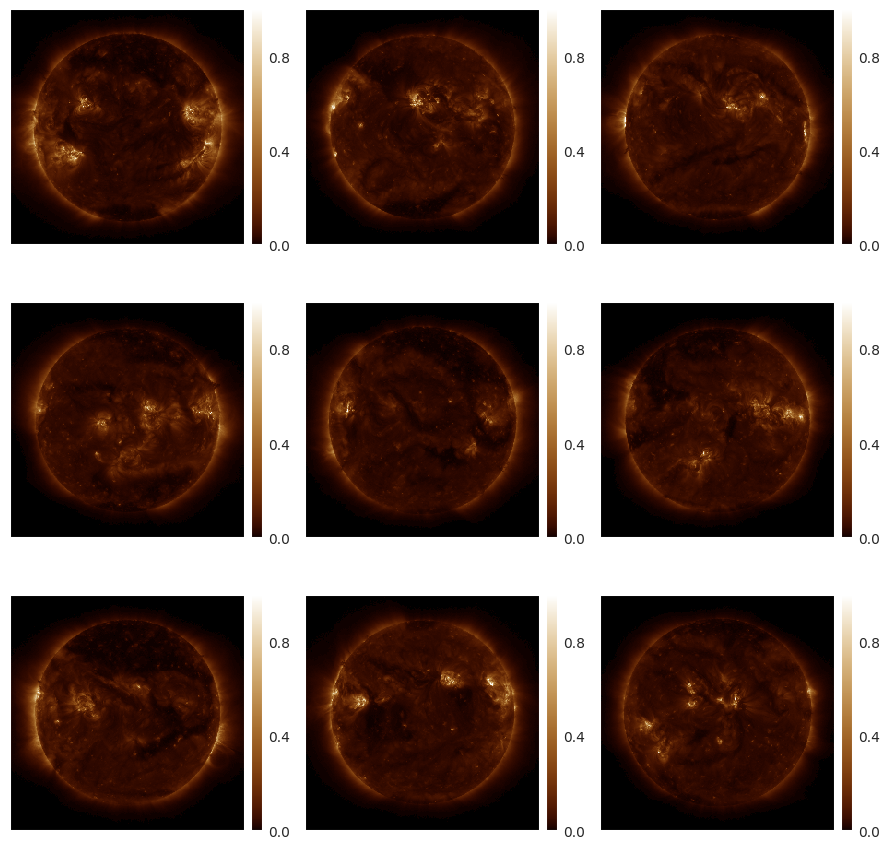

In [4]:
aia193_colormap = cm.color_tables.aia_color_table(193*u.angstrom)
isns.ImageGrid([i for i in AIA193_2016_mnorm[:9]], cmap=aia193_colormap, vmin=0, vmax=1)

## Training the model

In [5]:
latent_size = 256
# optimizer = keras.optimizers.Adam(learning_rate=0.0001)
optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
# optimizer = keras.optimizers.SGD()
# autoencoder, encoder, decoder = aem.gen_autoenc_model_1c(latent_size, optim=optimizer, loss="mse")
autoencoder, encoder, decoder = aem.gen_VAE_model_1c(latent_size, optim=optimizer, loss="mse")

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 8)  0           ['conv2d_1[0][0]']         

In [6]:
n_epochs = 300
batch_size = 128

history = autoencoder.fit(input_train, input_train, epochs=n_epochs,  validation_split=0.1, batch_size=batch_size)

Epoch 1/300


2023-05-06 22:21:49.139279: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


14/14 [==============================] - 11s 224ms/step - loss: 18950.4648 - val_loss: 16365.7480
Epoch 2/300
14/14 [==============================] - 1s 103ms/step - loss: 15380.9326 - val_loss: 15015.1152
Epoch 3/300
14/14 [==============================] - 1s 104ms/step - loss: 14170.5996 - val_loss: 13694.2480
Epoch 4/300
14/14 [==============================] - 1s 103ms/step - loss: 12289.3896 - val_loss: 11232.5977
Epoch 5/300
14/14 [==============================] - 1s 103ms/step - loss: 10855.1084 - val_loss: 10868.2832
Epoch 6/300
14/14 [==============================] - 1s 102ms/step - loss: 10619.0547 - val_loss: 10679.6553
Epoch 7/300
14/14 [==============================] - 1s 102ms/step - loss: 10455.6143 - val_loss: 10585.8516
Epoch 8/300
14/14 [==============================] - 1s 104ms/step - loss: 10318.5312 - val_loss: 10445.4688
Epoch 9/300
14/14 [==============================] - 1s 103ms/step - loss: 10214.0918 - val_loss: 10364.7754
Epoch 10/300
14/14 [==========

## Evaluating the model

20/20 [==============================] - 1s 20ms/step - loss: 9595.2920


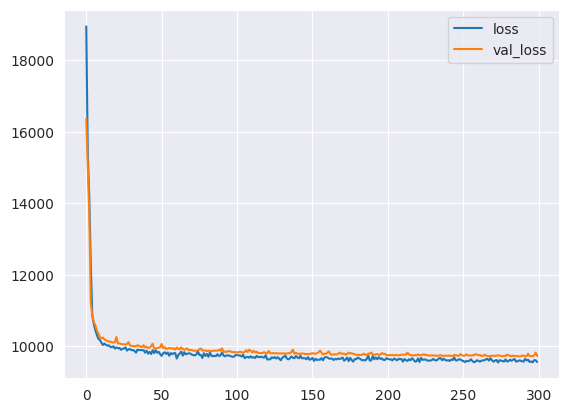

In [7]:
autoencoder.evaluate(input_test, input_test)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 119ms/step
[[-0.5238377  -0.13683876 -0.36451036 ... -0.6814371  -0.49325678
  -0.5692902 ]
 [-0.9525115  -0.54943264 -0.31205472 ... -0.6467871  -0.65359473
  -0.47595677]
 [-0.48716778 -0.4225771  -0.39614916 ... -0.30877054 -0.58769953
  -0.32326102]
 [-0.74668914 -0.6535896  -0.38957337 ... -0.36332083 -0.51482064
  -0.38628304]
 [-0.6426127  -0.5311481  -0.40433252 ... -0.6560369  -0.40986738
  -0.6488522 ]]


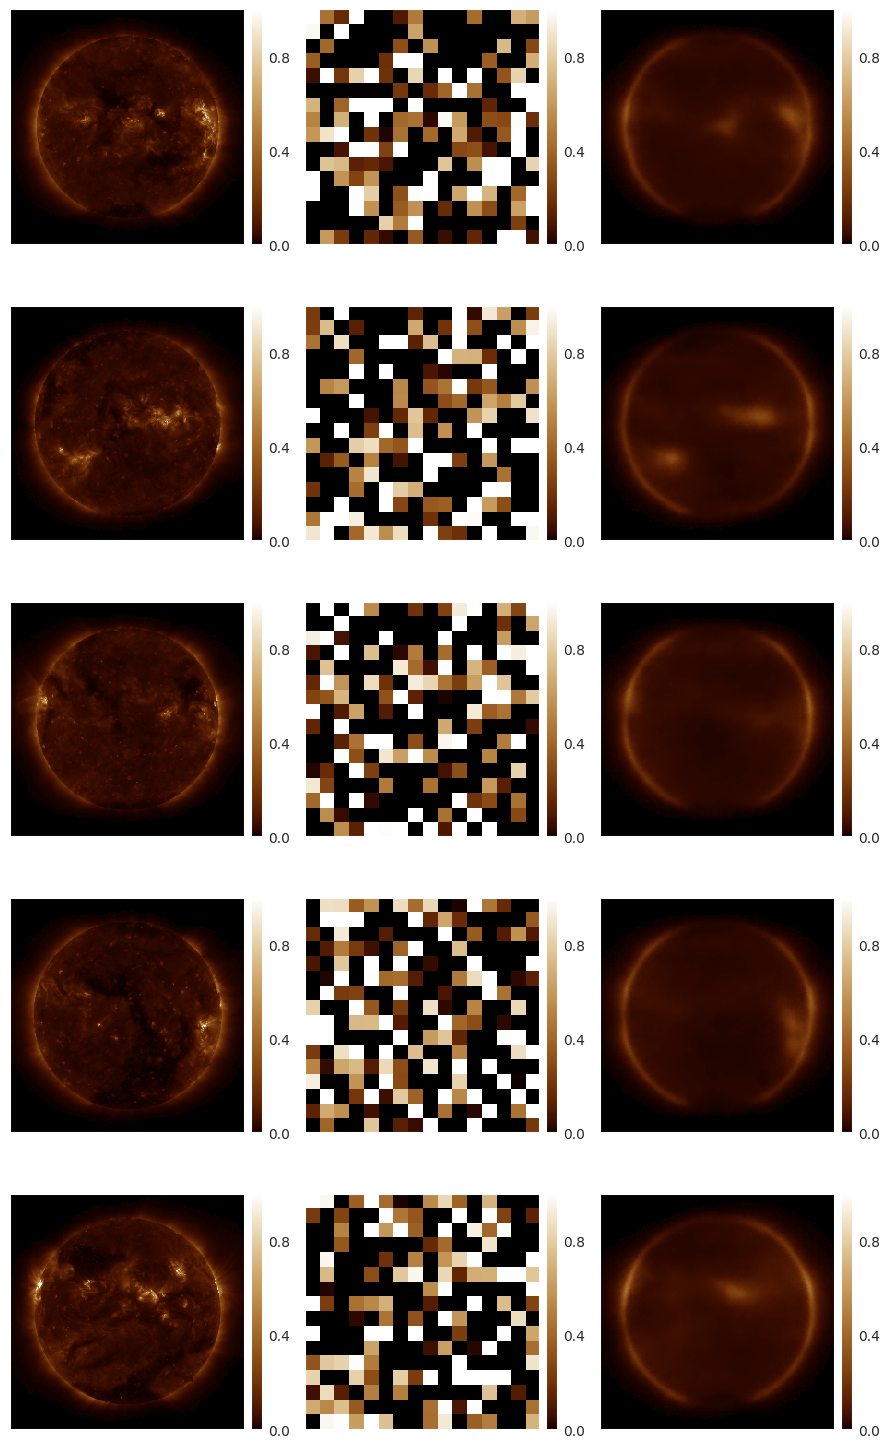

In [8]:
idx = np.random.permutation(80)[:5]

example = input_test[idx]
mean, var, code = encoder.predict(example)
print(var)
reconstructed = decoder(code)

images_zipped = [i for i in zip(example, code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.squeeze(i[0]))
    images.append(utils.square_dims_vector(i[1]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1, col_wrap=3)

1/1 [==============================] - 0s 8ms/step


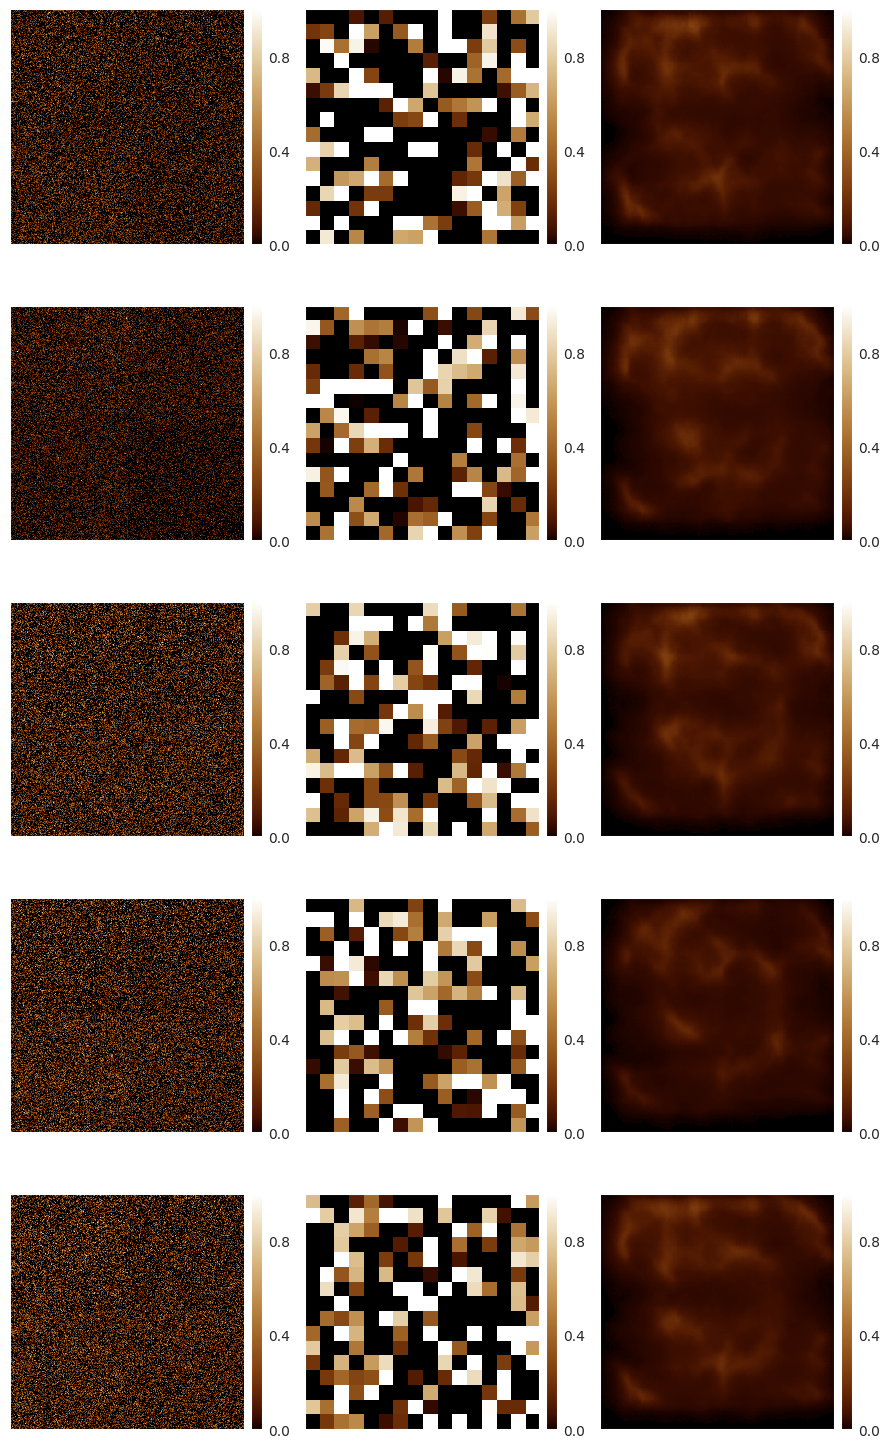

In [11]:
# Read images
file_list = glob.glob("data/aia_193A/2016*.fits")

noisy_file_list = [f for f in file_list if f in noise_imgs]

AIA193_2016_noise = sunpy.map.Map(noisy_file_list)
AIA193_2016_matrix_noise = np.array(list(d.data for d in AIA193_2016_noise))

# Normalize images
AIA193_2016_matrix_noise = np.clip(AIA193_2016_matrix_noise, 0, 5000)
min_values = AIA193_2016_matrix_noise.min(axis=2, keepdims=True).min(axis=1, keepdims=True)
max_values = AIA193_2016_matrix_noise.max(axis=2, keepdims=True).max(axis=1, keepdims=True)

rg = max_values - min_values
rg = np.maximum(rg, 1e-4*np.ones(rg.shape)) # To avoid dividing by 0

AIA193_2016_mnorm_noise = (AIA193_2016_matrix_noise-min_values) / rg

idx = np.random.permutation(len(noisy_file_list))[:5]

example = AIA193_2016_mnorm_noise[idx]
code = encoder.predict(example)[2]
reconstructed = decoder(code)

images_zipped = [i for i in zip(example, code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.squeeze(i[0]))
    images.append(utils.square_dims_vector(i[1]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1, col_wrap=3)

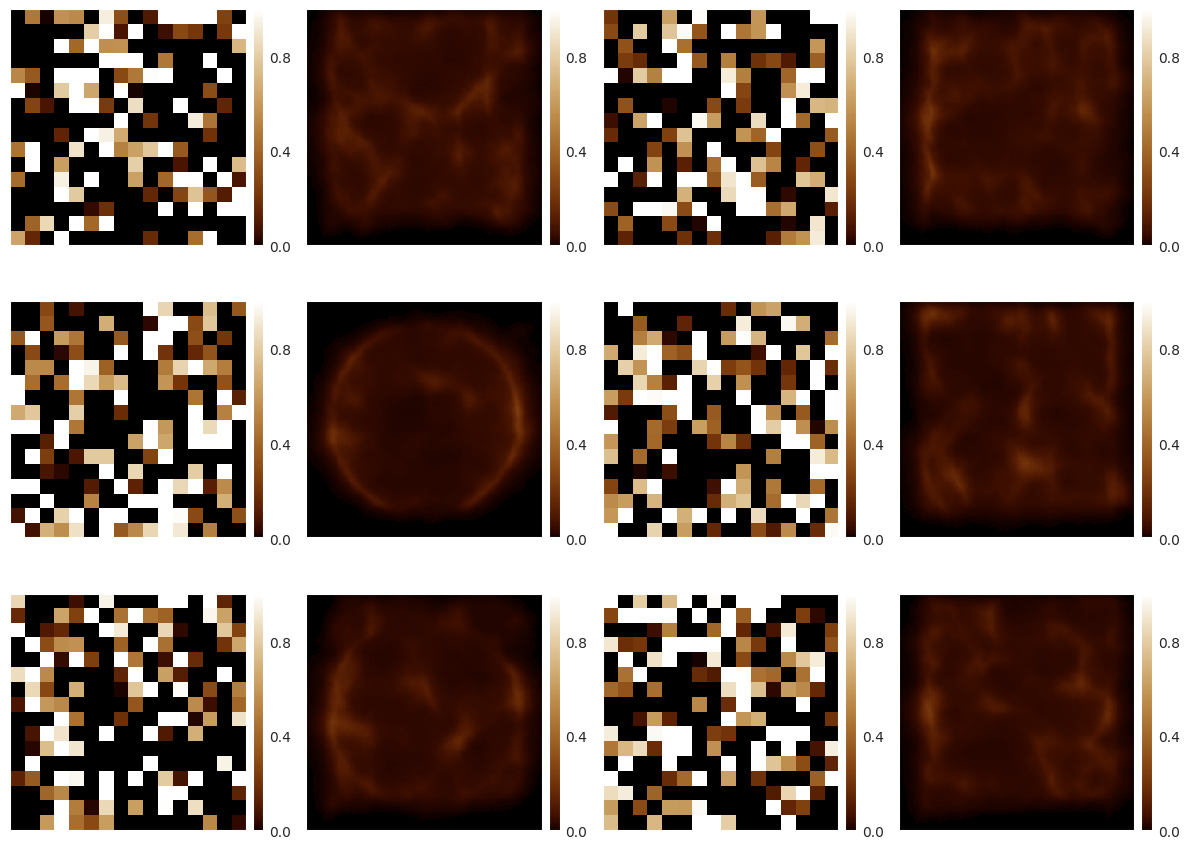

In [12]:
code = np.random.normal(0, 1, [6, latent_size])
reconstructed = decoder(code)

images_zipped = [i for i in zip(code, reconstructed)]
images = []

for i in images_zipped:
    images.append(utils.square_dims_vector(i[0]))
    images.append(np.squeeze(i[1]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1, col_wrap=4)